In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.stattools import grangercausalitytests
import scipy.optimize as sopt
import scipy.stats as s
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller

In [12]:
Case = pd.read_csv('/home/francesco/Codici/Computazionale/DC2/Italia/ripuliti/Case_Ripulite.csv')

Tassi = pd.read_csv('/home/francesco/Codici/Computazionale/DC2/Italia/ripuliti/Tassi_Ripuliti.csv')

datasets = [Case , Tassi ]

for i in datasets : 
    i.TIME = pd.to_datetime(i.TIME)
    i.TIME = i.TIME.apply(lambda dt : dt.replace(day = 1))
tot = Case

tot = tot.merge(Tassi , on = 'TIME')
tot = tot[tot.TIME <= '2020-12-01']
tot = tot[tot.TIME >= '2000-03-01']
TIME_tot = tot.TIME
tot.drop_duplicates(subset = 'TIME', inplace = True , ignore_index=True)
tot.rename(columns = { 'Index_Case' : 'Case'} , inplace = True )

Media = tot[tot.TIME.dt.year == 2010] 
tot.sort_values(by = 'TIME', inplace = True)

tot.Tassi = tot.Tassi / Media.Tassi.mean() * 100 

In [13]:
def traslo( Dataset) :     
    x_Dataset = pd.to_numeric(Dataset.TIME)
    
    y = Dataset.Case
    slope_case, intercept_case, r, p, se = s.linregress(x_Dataset, y)
    Traslati_Case =  y - slope_case * x_Dataset - intercept_case
    
    
    y = Dataset.Tassi
    slope_Tassi, intercept_Tassi, r, p, se = s.linregress(x_Dataset, y)
    Traslati_Tassi =  y - slope_Tassi * x_Dataset - intercept_Tassi

    appo= {'TIME' : x_Dataset}
    appo = pd.DataFrame(Dataset)
    appo.drop(columns=['Case','Tassi'],inplace=True)

    appo['Case'] = Traslati_Case

    appo['Tassi'] = Traslati_Tassi

    return appo , slope_case , intercept_case , slope_Tassi , intercept_Tassi

In [18]:
pre = 30
post = 60

q_case =[]
m_case = []
q_tassi = []
m_tassi = []

tot1 = tot[tot.TIME < tot.TIME[pre]]
tot2 = tot[tot.TIME >= tot.TIME[pre]]
tot2 = tot2[tot2.TIME < tot.TIME[post]]
tot3 = tot[tot.TIME >= tot.TIME[post]]
Pre2007 , m_casa , q_casa , m_tasso , q_tasso= traslo(tot1)
m_case.append(m_casa)
q_case.append(q_casa)
m_tassi.append(m_tasso)
q_tassi.append(q_tasso)
Post2015 , m_casa , q_casa , m_tasso , q_tasso= traslo(tot3)
m_case.append(m_casa)
q_case.append(q_casa)
m_tassi.append(m_tasso)
q_tassi.append(q_tasso)
Mezzo , m_casa , q_casa , m_tasso , q_tasso= traslo(tot2)
m_case.append(m_casa)
q_case.append(q_casa)
m_tassi.append(m_tasso)
q_tassi.append(q_tasso)
Traslato = Pre2007.merge(Mezzo , how = 'outer')
Traslato = Traslato.merge(Post2015 , how = 'outer')

train = Traslato[:int(0.8 * tot.index.max())-1]
test = Traslato[int(0.8 * tot.index.max()) - 1 : ]
train.sort_values(by = 'TIME' , inplace=True , ignore_index=True)
train.reset_index(drop = True , inplace=True )  
TIME = train.TIME
train.drop(columns = 'TIME' , inplace=True)

/tmp/ipykernel_3474/3670058443.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.sort_values(by = 'TIME' , inplace=True , ignore_index=True)
/tmp/ipykernel_3474/3670058443.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.drop(columns = 'TIME' , inplace=True)


In [15]:
model = VAR(train.astype(float))
result = model.fit(2)
result.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 25, Apr, 2023
Time:                     15:15:21
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    2.38021
Nobs:                     63.0000    HQIC:                   2.17383
Log likelihood:          -233.047    FPE:                    7.69600
AIC:                      2.04003    Det(Omega_mle):         6.60585
--------------------------------------------------------------------
Results for equation Case
              coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------
const           -0.014498         0.105464           -0.137           0.891
L1.Case          0.910172         0.131327            6.931           0.000
L1.Tassi         0.020872         0.024744            0.844           0.399
L2.Ca

<AxesSubplot: xlabel='TIME'>

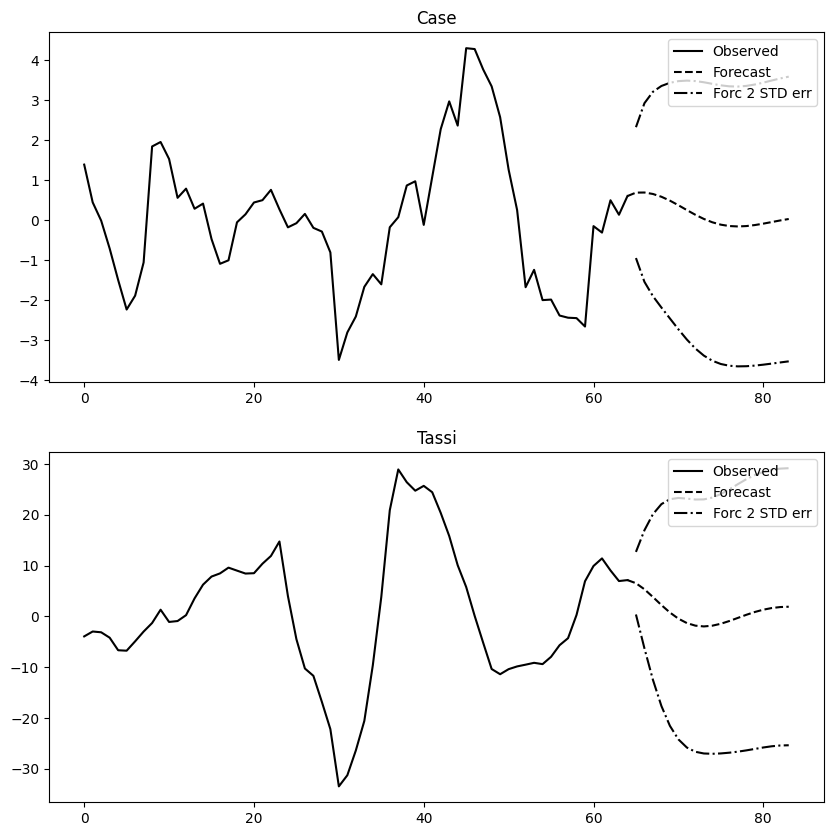

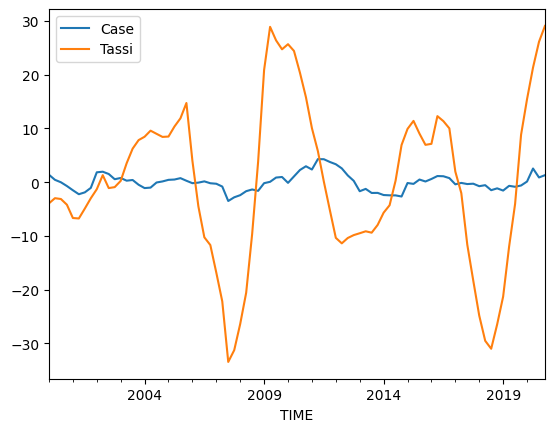

In [37]:
lag_order = result.k_ar
train.values[-lag_order:]
pred = result.forecast(y = train.values[-65:], steps =  65)
TIME
case_pred =[]
tassi_pred = []
for i in range(65):
    case_pred.append(pred[i][1])
    tassi_pred.append(pred[i][0])
futuro = TIME_tot - TIME
result.plot_forecast(19)
Traslato.plot(x = 'TIME')